In [2]:
'''
Packages

conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install -c anaconda scikit-learn
conda install pandas
'''

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import pearsonr


"""
Fix random seeds.
"""
seed=31
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
predictors = pd.read_csv("out_data/forest_data_poland_lucas.csv", sep=" ",  index_col=False, na_values = 48,
                         header = None)
pd.set_option('display.max_columns',None)


Better variable names

In [4]:
predictors_names = pd.read_csv("out_data/available_features_names.csv", sep=",",  index_col=False)
predictors.columns = predictors_names.name.tolist()
predictors.tail(5)

,GLAD_mean100m,GLAD_median100m,GLAD_mode100m,GLAD_q1,GLAD_q3,CLC10m_mean,CLC10m_median,CLC10m_mode.,CLC10m_q1,CLC10m_q3,CLC_01.vrt,C-GLOPS_mean,C-GLOPS_median,C-GLOPS_mode,C-GLOPS_q1,C-GLOPS_q3,JAXA_q3,JAXA_q1,JAXA_mode,JAXA_median,JAXA_mean
23079,0.246136,0,0,0,1,0.60,1,1,0,1,0,0.191063,0.07,0.07,0.04,0.08,0.5,0.0,0.0,0.0,0.277736
23080,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.016844,0.01,0.01,0.01,0.03,0.0,0.0,0.0,0.0,0.000000
23081,0.932173,1,1,1,1,0.95,1,1,1,1,1,0.402705,0.44,0.39,0.39,0.62,1.0,1.0,1.0,1.0,0.961699
23082,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.043004,0.03,0.03,0.02,0.03,0.0,0.0,0.0,0.0,0.023998
23083,0.000000,0,0,0,0,0.09,0,0,0,0,0,0.098559,0.09,0.06,0.06,0.11,0.0,0.0,0.0,0.0,0.000000


Now the left hand side

In [5]:
outcome = pd.read_csv("out_data/LUCAS/LUCAS_locations.csv", sep=",",  index_col=False)
outcome.tail(5)

,X,Y,LC1,LC1_PERC,forest
23079,5.278000e+06,3.114000e+06,C22,100,1
23080,5.278000e+06,3.136000e+06,B11,100,0
23081,5.294000e+06,3.150000e+06,C10,100,1
23082,5.294000e+06,3.172000e+06,B11,92,0
23083,5.286000e+06,3.116000e+06,Bx1,98,0


In [6]:
print (len(outcome))
print (len(predictors))

23084
23084


Split the Dataset

In [9]:
X    = predictors
Y    = outcome.iloc[:,4].to_frame()
feat = predictors.columns.values
print(X.shape)
print(Y.shape)
print(type(X))
print(type(Y))

(23084, 21)
(23084, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


There are a handful of NAs

In [10]:
na_rows = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
result = np.where(na_rows)[0]
print('NA rows: ' + str(result))

NA rows: [   33    54    58 ... 23032 23046 23077]


In [11]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])


In [12]:
print(X.shape)
print(Y.shape)

(21819, 21)
(21819, 1)


Create 4 dataset for training and testing the algorithm 

data.shape[1]: 21, n_plots_x: 5,n_plots_y: 5


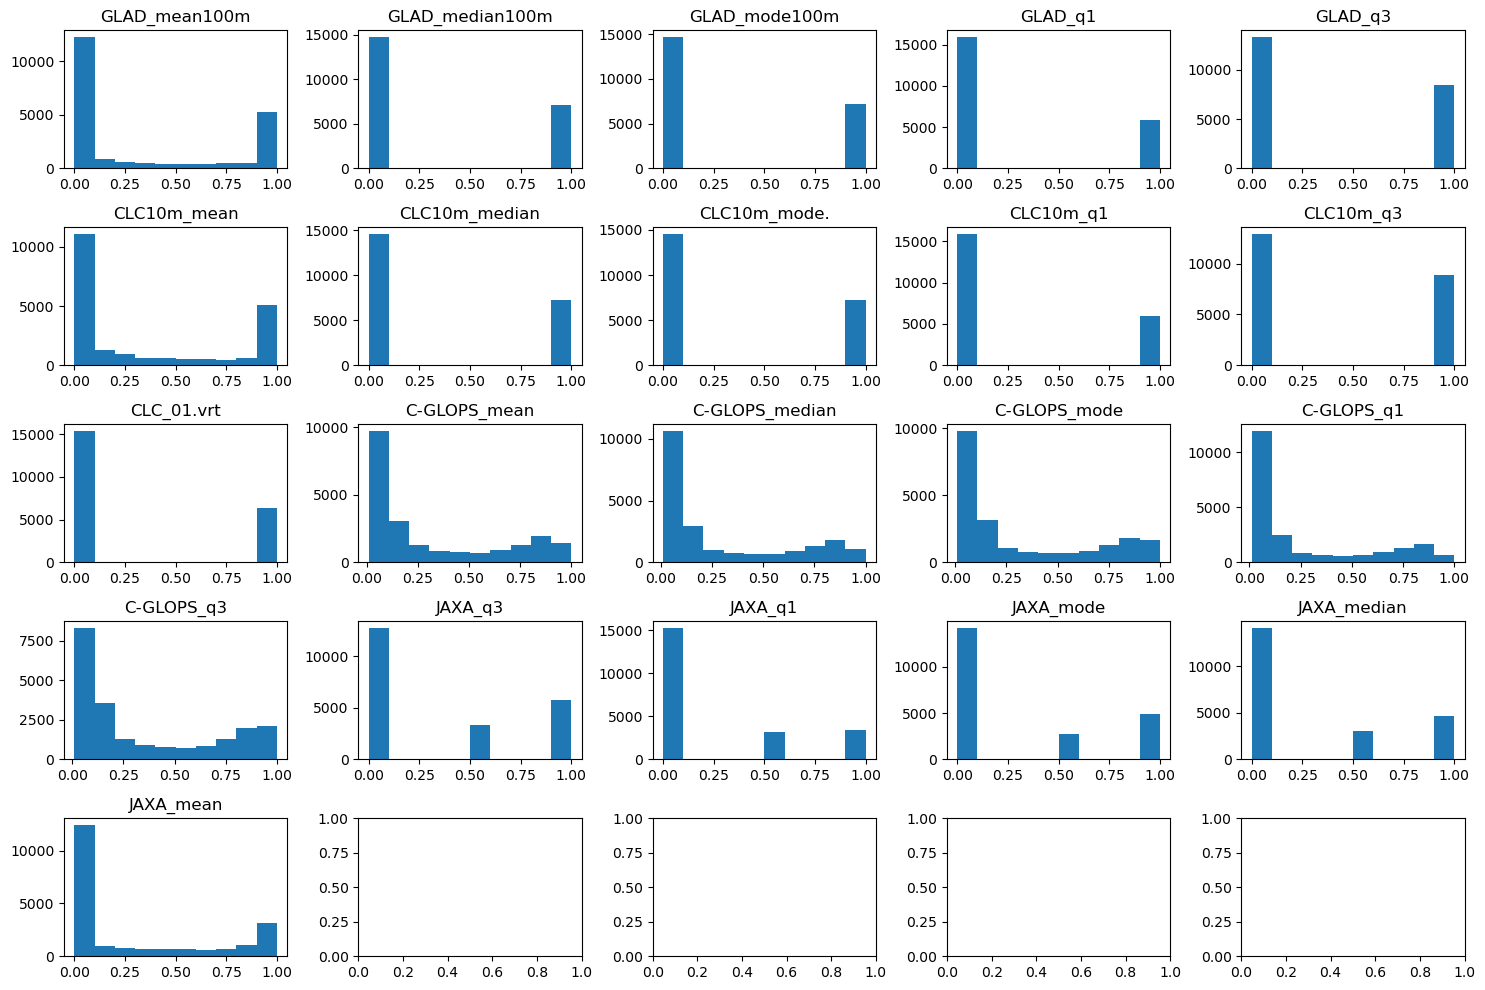

In [13]:
#Explore the raw data
n_plots_x = int(np.ceil(np.sqrt(X.shape[1])))
n_plots_y = int(np.ceil(np.sqrt(X.shape[1])))
print('data.shape[1]: {}, n_plots_x: {},n_plots_y: {}'.format(X.shape[1],n_plots_x,n_plots_y))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(X.shape[1]):
    ax[idx].hist(X.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(X.columns[idx])
fig.tight_layout()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=2023)


X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)


print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.min: {}, y_train.min: {}, y_test.min: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.max: {}, y_train.max: {}, y_test.max: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([15273, 21]), X_test.shape: torch.Size([6546, 21]), y_train.shape: torch.Size([15273, 1]), y_test.shape: torch.Size([6546, 1])
X_train.min: 0.0, X_test.min: 0.0, y_train.min: 0.0, y_test.min: 0.0
X_train.max: 1.0, X_test.max: 1.0, y_train.max: 1.0, y_test.max: 1.0


In [15]:
# Try with FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        output = self.sigmoid(self.fc3(hidden))

        return output


hid_dim: 128, lr: 0.75
Epoch 0, train_loss: 0.6813, val_loss: 0.6175, r_value: 0.8061
Epoch 500, train_loss: 0.2473, val_loss: 0.2479, r_value: 0.8182


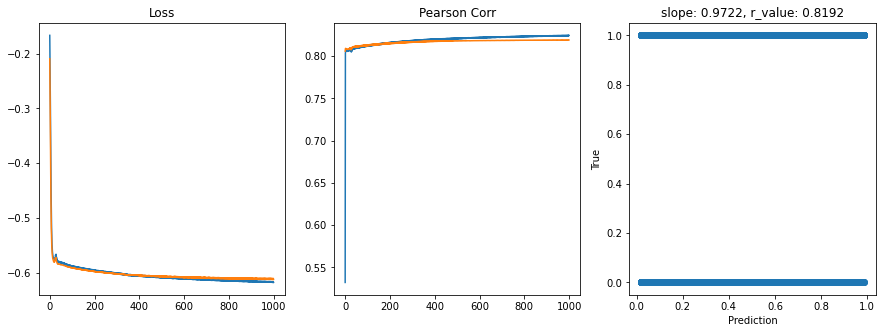


hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.6898, val_loss: 0.6509, r_value: 0.7924
Epoch 500, train_loss: 0.2472, val_loss: 0.2490, r_value: 0.8168


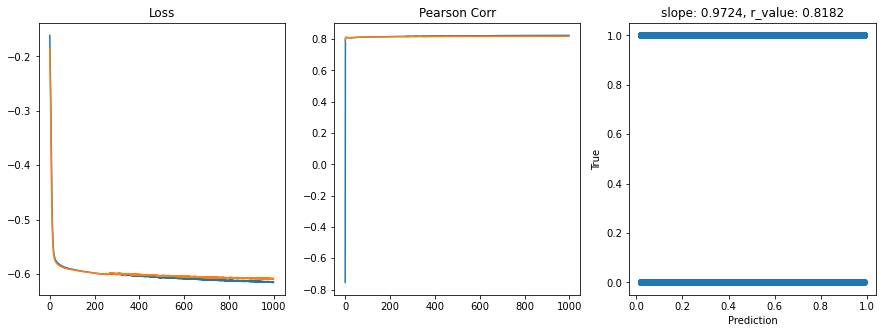


hid_dim: 128, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.6994, val_loss: 0.6877, r_value: 0.7678
Epoch 500, train_loss: 0.2562, val_loss: 0.2564, r_value: 0.8121


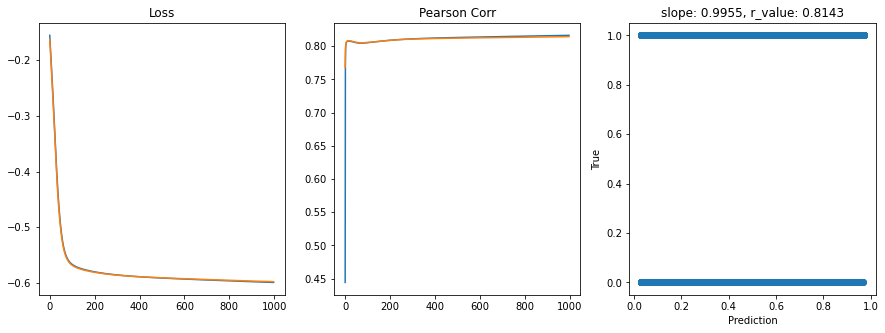


hid_dim: 128, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.6678, val_loss: 0.6667, r_value: 0.7331
Epoch 500, train_loss: 0.3141, val_loss: 0.3120, r_value: 0.8080


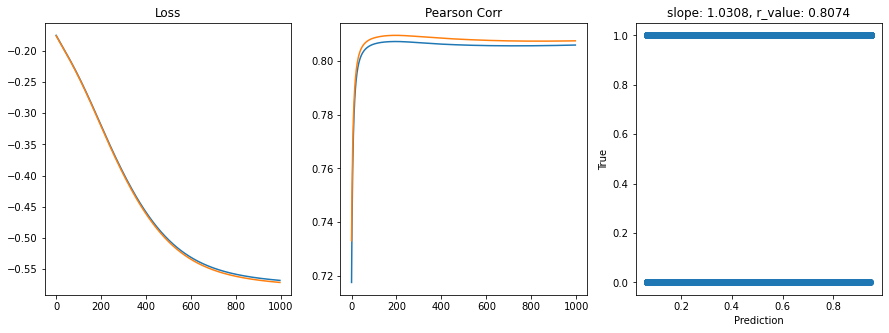


hid_dim: 128, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.7024, val_loss: 0.6964, r_value: 0.7817
Epoch 500, train_loss: 0.2617, val_loss: 0.2607, r_value: 0.8103


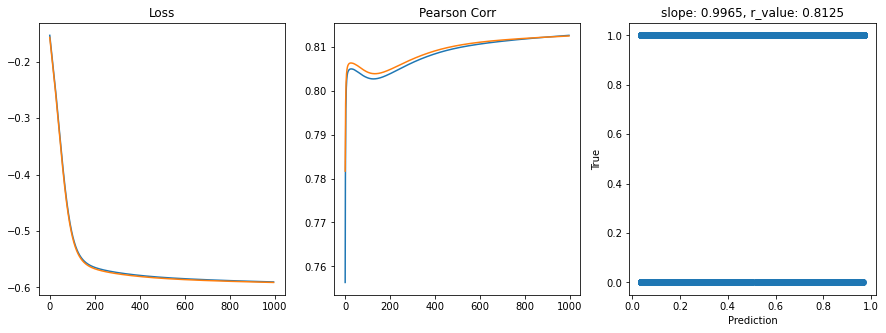


hid_dim: 256, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.6999, val_loss: 0.6064, r_value: 0.8091
Epoch 500, train_loss: 0.2456, val_loss: 0.2479, r_value: 0.8181


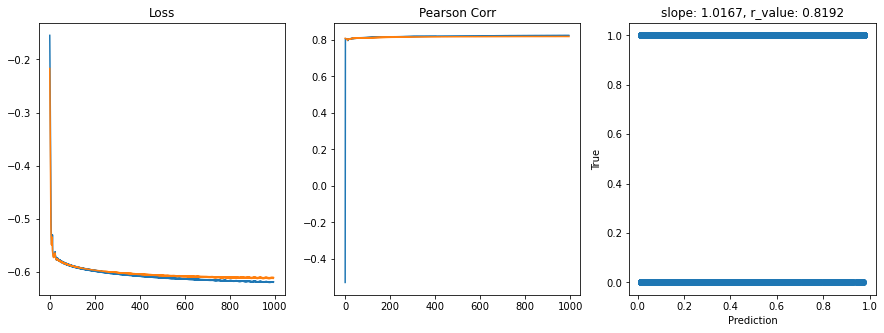


hid_dim: 256, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.7075, val_loss: 0.6306, r_value: 0.8078
Epoch 500, train_loss: 0.2477, val_loss: 0.2487, r_value: 0.8170


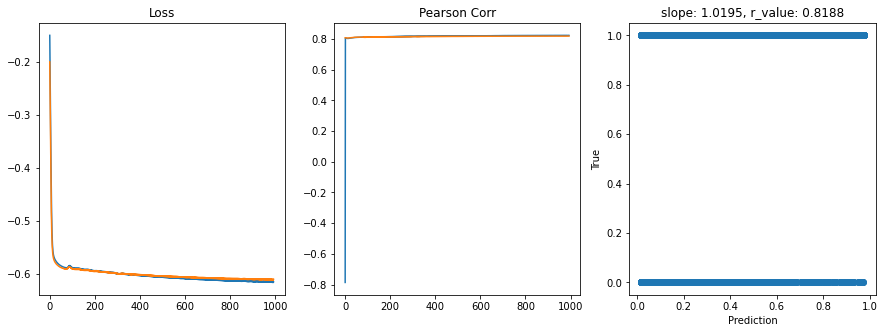


hid_dim: 256, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.6785, val_loss: 0.6643, r_value: 0.8056
Epoch 500, train_loss: 0.2545, val_loss: 0.2537, r_value: 0.8139


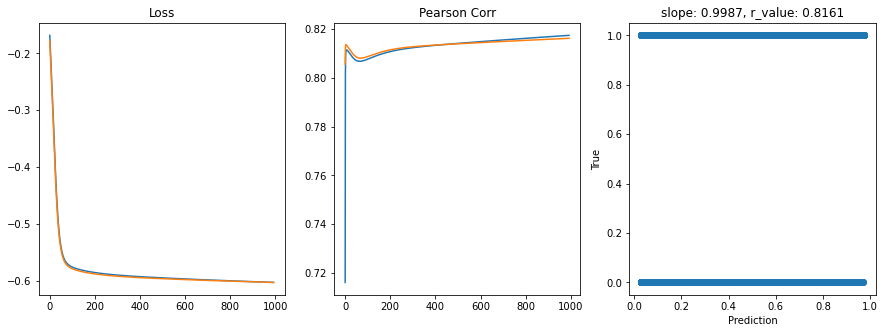


hid_dim: 256, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.6967, val_loss: 0.6952, r_value: -0.3042
Epoch 500, train_loss: 0.2980, val_loss: 0.2966, r_value: 0.8102


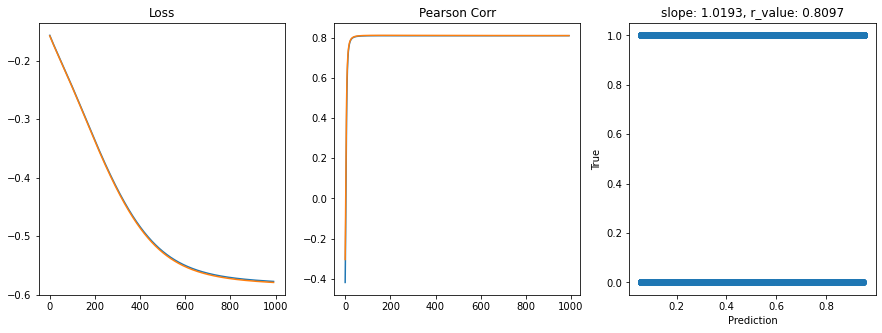


hid_dim: 256, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.7015, val_loss: 0.6932, r_value: -0.4398
Epoch 500, train_loss: 0.2595, val_loss: 0.2583, r_value: 0.8118


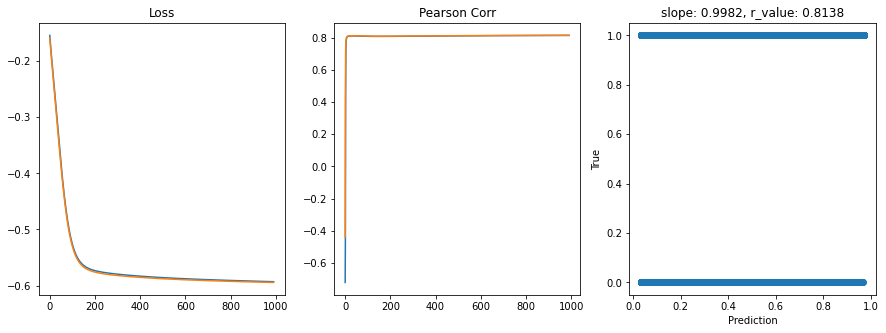


hid_dim: 512, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.6995, val_loss: 0.5703, r_value: 0.8122
Epoch 500, train_loss: 0.2433, val_loss: 0.2457, r_value: 0.8184


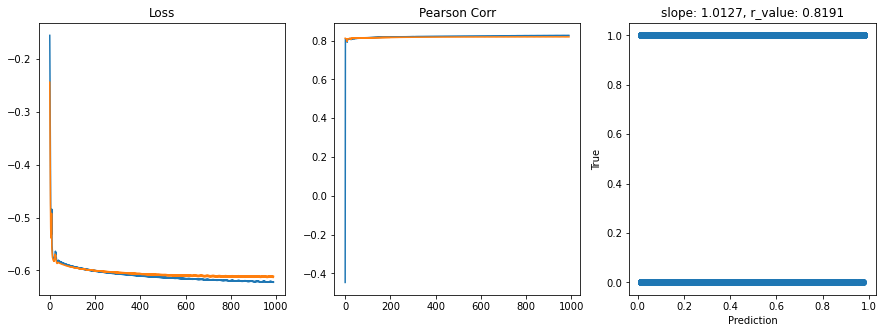


hid_dim: 512, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.6975, val_loss: 0.5979, r_value: 0.8103
Epoch 500, train_loss: 0.2454, val_loss: 0.2472, r_value: 0.8176


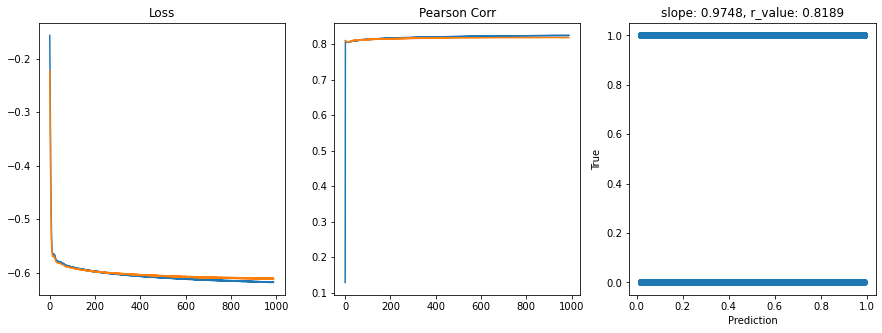


hid_dim: 512, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.6993, val_loss: 0.6726, r_value: 0.7701
Epoch 500, train_loss: 0.2533, val_loss: 0.2530, r_value: 0.8143


KeyboardInterrupt: 

In [16]:
# model.train()
epoch = 1000
hid_dim_range = [128,256,512]
lr_range = [0.75,0.5,0.1,0.01,0.05]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(X.shape[1], hid_dim).to(device)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))

            # Compute Loss
            loss = criterion(y_pred, y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            #y_pred = y_pred.cpu().detach().numpy().squeeze()

            
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred.cpu().detach().numpy().squeeze(),
                                                               y_train.cpu().detach().numpy().squeeze())
            all_r_train.append(r_value_train)


            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred, y_test.to(device))
                all_loss_val.append(loss.item())
                
                #y_pred = y_pred.cpu().detach().numpy().squeeze()

                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred.cpu().detach().numpy().squeeze(),
                                                                                     y_test.cpu().detach().numpy().squeeze())
                all_r_val.append(r_value)
                # r_value2 = pearsonr(y_pred, y_test)[0]
            
                if epoch%500==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()

In [34]:
# Try deeper FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        output = self.sigmoid(self.fc5(hidden))

        return output


hid_dim: 128, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.6958, val_loss: 0.6637, r_value: 0.7911
Epoch 500, train_loss: 0.2488, val_loss: 0.2512, r_value: 0.8173


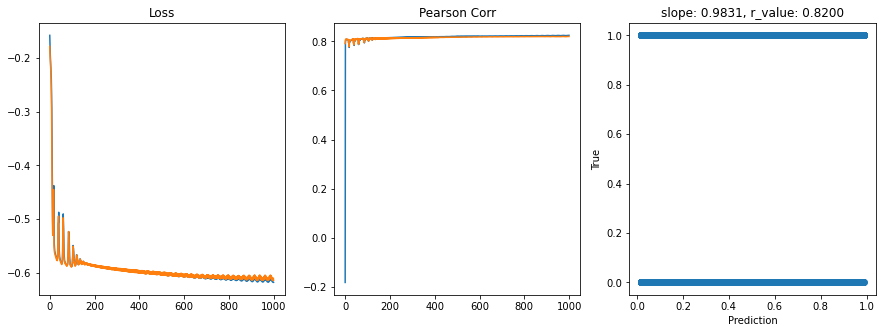


hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.7014, val_loss: 0.6760, r_value: 0.7666
Epoch 500, train_loss: 0.2453, val_loss: 0.2472, r_value: 0.8183


In [ ]:
# model.train()
epoch = 1000
hid_dim_range = [128,256,512]
lr_range = [0.75,0.5,0.1,0.01,0.05]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(X.shape[1], hid_dim).to(device)
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))

            # Compute Loss
            loss = criterion(y_pred, y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            #y_pred = y_pred.cpu().detach().numpy().squeeze()

            
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred.cpu().detach().numpy().squeeze(),
                                                               y_train.cpu().detach().numpy().squeeze())
            all_r_train.append(r_value_train)


            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred, y_test.to(device))
                all_loss_val.append(loss.item())
                
                #y_pred = y_pred.cpu().detach().numpy().squeeze()

                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred.cpu().detach().numpy().squeeze(),
                                                                                     y_test.cpu().detach().numpy().squeeze())
                all_r_val.append(r_value)
                # r_value2 = pearsonr(y_pred, y_test)[0]
            
                if epoch%500==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()